Import necessary libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import models
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

import random
random.seed(2022)

In [35]:
# Read the airlines data frame and set index as Month
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

### Differencing the Time Series

In [36]:
#taking log difference of the time series 
df['LogPassengers'] = np.log(df['Passengers'])
df['DiffLogPassengers'] = df['LogPassengers'].diff()
df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [37]:
#dividing data set into train and test sets. We keep only the last 12 values for the test set and remaining for the train set. 
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

## Function to convert Time Series Data to a supervised dataset

In [38]:
def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #by default the function takes the previous value at time t-1 and predicts the next prediction at t+1 unless specified. 
	n_vars = 1 
	df = pd.DataFrame(data)
	cols, col_names= list(), list()
	
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		col_names += [('x%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		
		cols.append(df.shift(-i))
		if i == 0:
			col_names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			col_names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns= col_names
	

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)

	return agg


series= df['DiffLogPassengers'].to_numpy()

#defining parameters for one step forecast
lags= 12

supervised_df = time_series_to_supervised(series, lags) #second parameter specifies the number of inputs as X (t-1, t-2,.... t-lags)

#building an array for the target variable from the above supervised time series data frame 
Y= supervised_df.iloc[:, -1].to_numpy()

#remove the target column to simply combine the input columns into a single array
supervised_df =supervised_df.drop(supervised_df.columns[-1],axis=1)

X= supervised_df.values

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (131, 12) Y.shape (131,)


In [39]:
#divide the data set into train and test sets
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

print("X.shape", Xtrain.shape, Xtest.shape,"\nY.shape", Ytrain.shape, Ytest.shape)

X.shape (119, 12) (12, 12) 
Y.shape (119,) (12,)


# Linear Regression based forecast

In [40]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
print('Train accuracy: ', lr.score(Xtrain, Ytrain))
print('Test accuracy: ', lr.score(Xtest, Ytest))

Train accuracy:  0.8602836107633467
Test accuracy:  0.8259209649468484


We can see that the R2 scores for both train and test sets are not that great

In [41]:
# Boolean index- create indexing to address train and test sets
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:lags+1] = False # first lag+1 values are not predictable

In [42]:
#Reverse the differencing operation to get the data back to original format
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

# 1-step forecast

In [43]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

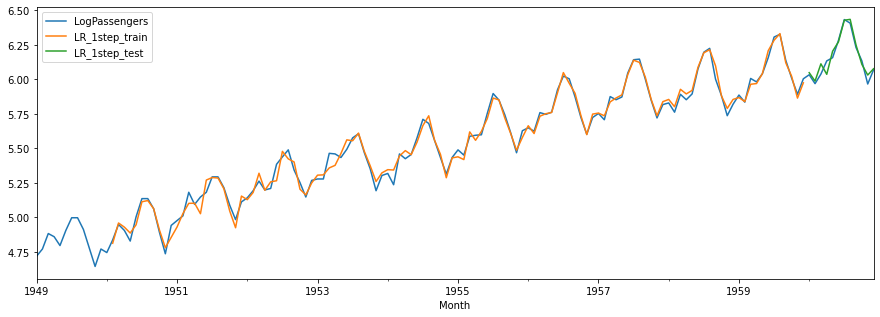

In [44]:
# plot 1-step forecast
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

## Performing One-Step Forecast with N other models from sklearn package

In [45]:
#PREPROCESSING AND TRAIN TEST SPLIT


def preprocessing(data_series, target_column, lags=1, n_forecast= 1): 
	#default values for the lags and n_forecast is set to 1
	#taking log difference of the time series 
	data_series['Log'+target_column] = np.log(data_series[target_column])
	data_series['DiffLog'+target_column] = data_series['Log'+target_column].diff()

	#we will work with the differenced time series data
	series= data_series['DiffLog'+target_column].to_numpy()

	#Convert the time series input data to a supervised dataframe for ML models\
	#second parameter specifies the number of inputs as X (t-1, t-2,.... t-lags)
	supervised_df = time_series_to_supervised(series, lags, n_forecast) 
	print(supervised_df.head())

	# Setting the input data 
	X= supervised_df.iloc[:, 0:lags].to_numpy()
	print(X)

	#building an array for the target variable from the above supervised time series data frame 
	Y= supervised_df.iloc[:, lags:].to_numpy()
	print(Y)

	#divide the data set into train and test sets
	Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
	Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

	print("X.shape", Xtrain.shape, Xtest.shape,"\nY.shape", Ytrain.shape, Ytest.shape)
	return Xtrain, Ytrain, Xtest, Ytest

#CONVERT TIME SERIES DATA TO A SUPERVISED DATA FRAME

def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #by default the function takes the previous value at time t-1 and predicts the next prediction at t+1 unless specified. 
	n_vars = 1 
	df = pd.DataFrame(data)
	cols, col_names= list(), list()
	
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		col_names += [('x%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			col_names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			col_names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns= col_names
	

	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)

	print(agg.head())

	return agg



In [46]:
#define data set parameters- Univariate forecasting (SINGLE PREDICTOR COLUMN)
dataset='shampoo_sales.csv'
index_column='Month'
target_column='Sales'

# set parameters for forecasting
lags= 10
n_forecast= 10
Ntest= 12

# read the data set and apply train test split
df = pd.read_csv(dataset, index_col=index_column, parse_dates=True)
Xtrain, Ytrain, Xtest, Ytest = preprocessing(df, target_column, n_forecast)



    x1(t-10)   x1(t-9)   x1(t-8)   x1(t-7)   x1(t-6)   x1(t-5)   x1(t-4)  \
11 -0.600575  0.227111 -0.428391  0.412981 -0.067686  0.318939 -0.031999   
12  0.227111 -0.428391  0.412981 -0.067686  0.318939 -0.031999 -0.152222   
13 -0.428391  0.412981 -0.067686  0.318939 -0.031999 -0.152222 -0.450282   
14  0.412981 -0.067686  0.318939 -0.031999 -0.152222 -0.450282  1.007227   
15 -0.067686  0.318939 -0.031999 -0.152222 -0.450282  1.007227 -0.593389   

     x1(t-3)   x1(t-2)   x1(t-1)     y1(t)  
11 -0.152222 -0.450282  1.007227 -0.593389  
12 -0.450282  1.007227 -0.593389  0.044194  
13  1.007227 -0.593389  0.044194 -0.262107  
14 -0.593389  0.044194 -0.262107  0.340287  
15  0.044194 -0.262107  0.340287  0.262986  
    x1(t-10)   x1(t-9)   x1(t-8)   x1(t-7)   x1(t-6)   x1(t-5)   x1(t-4)  \
11 -0.600575  0.227111 -0.428391  0.412981 -0.067686  0.318939 -0.031999   
12  0.227111 -0.428391  0.412981 -0.067686  0.318939 -0.031999 -0.152222   
13 -0.428391  0.412981 -0.067686  0.318939 -0

In [47]:

Xtrain, Ytrain, Xtest, Ytest= train_test_split(df, target_column)

print("X.shape", Xtrain.shape, Xtest.shape,"\nY.shape", Ytrain.shape, Ytest.shape)

TypeError: train_test_split() takes 0 positional arguments but 2 were given

In [ ]:
# Read the airlines data frame and set index as Month
dataset='shampoo_sales.csv'
index_column='Month'
target_column='Sales'


df = pd.read_csv(dataset, index_col=index_column, parse_dates=True)
preprocessing(df, target_column)


#CONVERT TIME SERIES DATA TO A SUPERVISED DATA FRAME
# def time_series_to_supervised(data, n_in=1, n_out=1, dropnan=True): #by default the function takes the previous value at time t-1 and predicts the next prediction at t+1 unless specified. 
# 	n_vars = 1 
# 	df = pd.DataFrame(data)
# 	cols, col_names= list(), list()
	
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		col_names += [('x%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
		
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			col_names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			col_names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
# 	# put it all together
# 	agg = pd.concat(cols, axis=1)
# 	agg.columns= col_names
	

# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)

# 	return agg


# PRE-PROCESSING
def preprocessing(data_series, lags=1, n_forecast= 1): #default values for the lags and n_forecast is set to 1
    
    #taking log difference of the time series 
    data_series['Log'+target_column] = np.log(data_series[target_column])
    data_series['DiffLog'+target_column] = data_series['Log'+target_column].diff()
    data_series.head()

    #we will work with the differenced time series data
    series= data_series['DiffLog'+target_column].to_numpy()

    supervised_df = time_series_to_supervised(series, lags, n_forecast) #second parameter specifies the number of inputs as X (t-1, t-2,.... t-lags)

    # Setting the input data 
    X= supervised_df.iloc[:, 0:lags].to_numpy()

    #building an array for the target variable from the above supervised time series data frame 
    Y= supervised_df.iloc[:, lags:].to_numpy()

    #divide the data set into train and test sets
    Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
    Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

    print("X.shape", Xtrain.shape, Xtest.shape,"\nY.shape", Ytrain.shape, Ytest.shape)
    return Xtrain, Ytrain, Xtest, Ytest


# # MODEL PREDICTIONS
# def N_step_forecast(model):
#     model_results={}
#     result_df=pd.DataFrame()

#     if isinstance(model, list):
#         model_names=[]
#         train_r2=[]
#         test_r2=[]

#         #Reverse the differencing operation to get the data back to original format
#         df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
#         prev = df['ShiftLogPassengers']

#         for model_n in model:
#             model_n.fit(Xtrain, Ytrain)

#             # 1-step forecast
#             model_name = type(model_n).__name__
#             model_names.append(model_name)
#             train_r2.append(model_n.score(Xtrain, Ytrain))
#             test_r2.append(model_n.score(Xtest, Ytest))
        
#             df.loc[train_idx, model_name+'_'+n_forecast+'step_train'] = prev[train_idx] + model.predict(Xtrain)
#             df.loc[test_idx, model_name+'_'+n_forecast+'step_train'] = prev[test_idx] + model.predict(Xtest)

#             # plot 1-step forecast
#             df[['LogPassengers', model_name+'_'+n_forecast+'step_train', model_name+'_'+n_forecast+'step_train']].plot(figsize=(15, 5))

    
#     else:
#         model.fit(Xtrain, Ytrain)

#         # N-step forecast
#         model_name = type(model).__name__
#         model_names.append(model_name)
#         train_r2.append(model_n.score(Xtrain, Ytrain))
#         test_r2.append(model_n.score(Xtest, Ytest))

#         df.loc[train_idx, model_name+'_'+n_forecast+'step_train'] = prev[train_idx] + model.predict(Xtrain)
#         df.loc[test_idx, model_name+'_'+n_forecast+'step_train'] = prev[test_idx] + model.predict(Xtest)

#         # plot 1-step forecast
#         df[['LogPassengers', model_name+'_'+n_forecast+'step_train', model_name+'_'+n_forecast+'step_train']].plot(figsize=(15, 5))
    

#     model_results= {'Model Name': model_names, 'Train Accuracy': train_r2, 
#         'Test Accuracy': test_r2}

#     #create data frame to display results
#     results_agg= pd.DataFrame(model_results)
#     print(results_agg)
    

# #defining parameters for one step forecast
# lags= 12
# n_forecast= 30

# N_step_forecast([LinearRegression(), SVR(), RandomForestRegressor()])


NameError: name 'preprocessing' is not defined

#### We can see that the Random Forest model has performed better than the rest. But the test accuracy (for unseen data) for Random Forest is poor as compared to its train accuracy. Let's try predicting values for multiple time steps in the future. 

## Multi-Step or Sequence Forecasting

##### The above function time_series_to_supervised() can be used for multi-step forecasting. The n_out i.e. specified number of outputs in the future/ predictions changes. 

In [ ]:
#defining parameters for one step forecast
n_forecast= 10
supervised_df = time_series_to_supervised(series, lags, n_forecast) #second parameter specifies the number of inputs as X (t-1, t-2,.... t-lags)

# Setting the input data sets and target sets
X= supervised_df.iloc[:, 0:lags].to_numpy()

#building an array for the target variable from the above supervised time series data frame 
Y= supervised_df.iloc[:, lags:].to_numpy()


    x1(t-10)   x1(t-9)   x1(t-8)   x1(t-7)   x1(t-6)   x1(t-5)   x1(t-4)  \
11  0.052186  0.112117 -0.022990 -0.064022  0.109484  0.091937  0.000000   
12  0.112117 -0.022990 -0.064022  0.109484  0.091937  0.000000 -0.084557   
13 -0.022990 -0.064022  0.109484  0.091937  0.000000 -0.084557 -0.133531   
14 -0.064022  0.109484  0.091937  0.000000 -0.084557 -0.133531 -0.134733   
15  0.109484  0.091937  0.000000 -0.084557 -0.133531 -0.134733  0.126294   

     x1(t-3)   x1(t-2)   x1(t-1)     y1(t)   y1(t+1)   y1(t+2)   y1(t+3)  \
11 -0.084557 -0.133531 -0.134733  0.126294 -0.025752  0.091350  0.112478   
12 -0.133531 -0.134733  0.126294 -0.025752  0.091350  0.112478 -0.043485   
13 -0.134733  0.126294 -0.025752  0.091350  0.112478 -0.043485 -0.076961   
14  0.126294 -0.025752  0.091350  0.112478 -0.043485 -0.076961  0.175633   
15 -0.025752  0.091350  0.112478 -0.043485 -0.076961  0.175633  0.131852   

     y1(t+4)   y1(t+5)   y1(t+6)   y1(t+7)   y1(t+8)   y1(t+9)  
11 -0.043485 -0.07696

In [ ]:
#divide the data set into train and test sets
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

print("X.shape", Xtrain.shape, Xtest.shape,"\nY.shape", Ytrain.shape, Ytest.shape)


lr =()
lr.fit(Xtrain, Ytrain)

print('Train accuracy: ', lr.score(Xtrain, Ytrain))
print('Test accuracy: ', lr.score(Xtest, Ytest))

X.shape (112, 10) (12, 10) 
Y.shape (112, 10) (12, 10)


ValueError: y should be a 1d array, got an array of shape (112, 10) instead.